# Experimentation notebook

Here, I have performed experiements with the data, models and techniques that could be added to the model. Some techniques need further testing before integrating into the model. Hence, for POC purpose and understanding the key ideas I have utilised this notebook. 

- FINGPT [Project link](https://github.com/xandie985/RAGFinanceChatBot/tree/main)
- Developed by: Sandeep Kumar Kushwaha [LinkedIn](https://www.linkedin.com/in/xandie985/)




## Data Ingestion

In [ ]:
!brew install x265 libjpeg libde265 libheif
!pip install --upgrade pip
!pip install --upgrade pillow-heif --no-binary :all:
!pip install unstructured-inference
!pip install -qU langchain-text-splitters
!pip install unstructured
!pip install pdfminer.six
!pip install pdf2img
!pip install opencv-python

In [18]:
import os
from typing import List
from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_community.embeddings import OpenAIEmbeddings

from pyprojroot import here
import warnings; warnings.filterwarnings("ignore")
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=here(".env"))

True

In [44]:
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("The OPENAI_API_KEY environment variable is not set.")
os.environ["OPENAI_API_KEY"] = api_key

#### Setting Prompts for LLM

In [167]:
system_prompt = """You are the The Best Financial Research Analyst. \
    You are expert in analyzing financial statements, forecasting financial performance, \
    valuing the company, assessing investment opportunities and preparing research reports. \
    You will recieve a chat history, retrieved content from the vectorDB based on the user's question, and the source.\ 
    Your task is to respond to the user's question using the information \
    from the vectorDB and Chat history, without relying on your own knowledge. \
    Your output should contain only your response, and if you can't find relevant context say that you don't know. \
    You will receive a input prompt enclosed in triple backtics:

    # Retrieved content number:\n
    Content\n\n
    Source\n\n

    # User question:\n 
    """

query_rewriting_prompt = """You are an AI specializing in financial analysis, trained to enhance query precision for retrieving information from financial databases.\
    Your task is to rewrite queries to be more specific and focused on financial concepts, terminology, and metrics relevant to a senior analyst.\
    Consider the following when rewriting:
    * Specificity: Clarify ambiguous terms or abbreviations (e.g., "EPS" to "Earnings Per Share").
    * Financial Metrics:  Incorporate relevant financial metrics or ratios (e.g., "profit" to "net income" or "ROE").
    * Time Period:  If not specified, include a relevant time frame (e.g., "last quarter," "fiscal year 2023").
    * Company/Industry Context:  Add company names or industry terms if relevant (e.g., "tech company valuations").
    * Financial Statement Focus: Specify the financial statement if applicable (e.g., "balance sheet," "income statement," "cash flow statement").

    Examples:

    Original Query: "How did the company Google do last year?"
    Rewritten Query: "What was the Google's net income and revenue growth in the last fiscal year?"

    Original Query: "NVIDIA Stock performance?"
    Rewritten Query: "What was the NVIDIA's stock price performance (e.g., year-to-date return, 52-week high/low) and trading volume?"

    Original Query: "Profit margin Q2 2024 Microsoft companies?"
    Rewritten Query: "What is the average net profit margin for Microsoft in Q2 2024?"

    Original Query: "Debt level NVIDIA?"
    Rewritten Query: "What is the NVIDIA's total debt-to-equity ratio as of the most recent quarter?"

    Original Query: "Cash flow from operations?"
    Rewritten Query: "What was the company's cash flow from operations in the last fiscal year, and how does it compare to the prior year?"

    Your goal is to rewrite queries to be clear, unambiguous, and aligned with the analytical needs of a senior financial professional. """

query_expansion_prompt= """ You are a financial analyst assistant that breaks down a user's financial analysis query into sub-queries.\
    The sub-queries should be mutually exclusive and collectively exhaustive, focusing on different aspects of financial analysis.\
    Your response will be a JSON object with a `queries` field, which is a list of `query` objects, each detailing a specific aspect of the financial analysis.\
    """

# user queries examples
incomplete_messg = "Revenue NVIDIA?"
message = "Who is the CEO of Alphabet Inc?" 
message1 = "What is the Commission file number on Alphabet's report?" #APLHABET: 001-37580  | pg1
message2 = "What was the balance at Beginning at Year December 31, 2021 for Alphabet?" # ALPHABET: USD 1,344 | pg 91
message4 = "What was the Total Fees Billed by the Independent Registered Public Accounting Firm in Fiscal 2023 for NVIDIA?" # [NVIDIA: USD 8,308,800 |pg 68]
message3 = "What was the balance at End at Year December 31, 2021 for Alphabet and by what margin did the Revenue increased $13.6 billion for Microsoft in 2023 compare to fiscal 2022?" #[GOOGL: USD 1,389 | pg 91] [MSFT: 7% | pg31]

In [22]:
# settings for models and other config

llm_model="gpt-4o-mini"
temperature = 0.2
embeddings = OpenAIEmbeddings()

### Setting up Directory Paths, Loading and processing docs

In [23]:

directory_path = here("data/docs")

In [24]:
def load_docs(directory_path):
    """Loads all PDF files from the directory and splits them into chunks."""
    pdf_files = [f for f in os.listdir(directory_path) if f.endswith(".pdf")]
    print("Number of PDF files:", len(pdf_files))
    
    docs = []
    document_file_paths = []  # Initialize the list to store file paths
    
    for pdf_file in pdf_files:
        file_path = os.path.join(directory_path, pdf_file)
        loader = PyPDFLoader(file_path)
        docs.extend(loader.load())
        document_file_paths.append(file_path)  # Add the file path to the list
    
    print("Number of documents:", len(docs))

    return docs, document_file_paths

In [25]:
doc_pages, doc_file_paths =load_docs(directory_path)

Number of PDF files: 3
Number of documents: 351


### Splitting documents via Recursive Character Text Splitter

In [26]:
import matplotlib.pyplot as plt

def split_documentsRCTS(docs: List, chunk_size: int = 1000, chunk_overlap: int = 200):
    """Splits documents into chunks of specified size."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""]
    )
    chunked_documents = text_splitter.split_documents(docs)
    len_chunk = []
    word_count = []
    for chunk in chunked_documents:
        word_count.append(len(chunk.page_content.split()))
        len_chunk.append(len(chunk.page_content))
    return chunked_documents, len_chunk, word_count

import matplotlib.pyplot as plt

def plot_chunks_and_words(len_chunk, word_count, heading, num_bins=100):
    """Plots histograms of chunk lengths and word counts with descriptive statistics."""

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create two subplots side-by-side

    # Plot Chunk Lengths
    axes[0].hist(len_chunk, bins=num_bins, color='skyblue', alpha=0.7, label='Chunk Length')
    axes[0].set_title(f"{heading} - Chunk Lengths")
    axes[0].set_xlabel("Chunk Length (Characters)")
    axes[0].set_ylabel("Frequency")

    # Add chunk length statistics
    min_len = min(len_chunk)
    max_len = max(len_chunk)
    mean_len = sum(len_chunk) / len(len_chunk)
    axes[0].text(0.95, 0.95, f'Min: {min_len}', transform=axes[0].transAxes, verticalalignment='top', horizontalalignment='right', color='red', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[0].text(0.95, 0.90, f'Max: {max_len}', transform=axes[0].transAxes, verticalalignment='top', horizontalalignment='right', color='red', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[0].text(0.95, 0.85, f'Mean: {mean_len:.2f}', transform=axes[0].transAxes, verticalalignment='top', horizontalalignment='right', color='red', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Plot Word Counts
    axes[1].hist(word_count, bins=num_bins, color='lightgreen', alpha=0.7, label='Word Count')
    axes[1].set_title(f"{heading} - Word Counts")
    axes[1].set_xlabel("Word Count")
    axes[1].set_ylabel("Frequency")

    # Add word count statistics
    min_words = min(word_count)
    max_words = max(word_count)
    mean_words = sum(word_count) / len(word_count)
    axes[1].text(0.95, 0.95, f'Min: {min_words}', transform=axes[1].transAxes, verticalalignment='top', horizontalalignment='right', color='red', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1].text(0.95, 0.90, f'Max: {max_words}', transform=axes[1].transAxes, verticalalignment='top', horizontalalignment='right', color='red', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1].text(0.95, 0.85, f'Mean: {mean_words:.2f}', transform=axes[1].transAxes, verticalalignment='top', horizontalalignment='right', color='red', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
   
    plt.show()


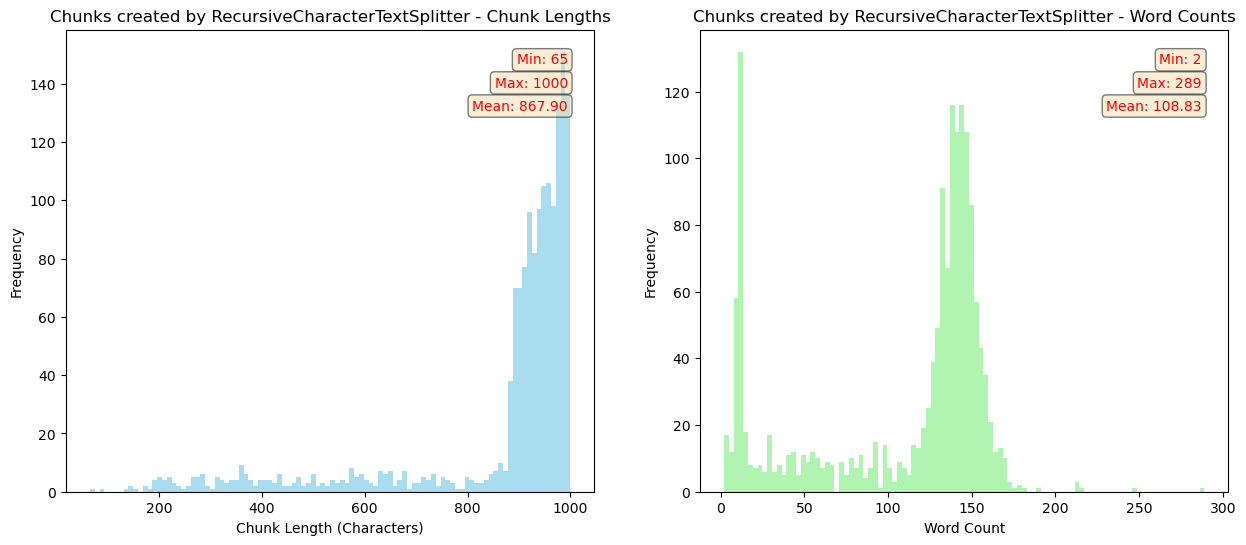

In [27]:
RCTS_chunked_documents, RCTS_len_chunks, RCTS_word_count = split_documentsRCTS(doc_pages, chunk_size=1000, chunk_overlap=200)
plot_chunks_and_words(RCTS_len_chunks, RCTS_word_count, "Chunks created by RecursiveCharacterTextSplitter")

### Chunking and Processing data with UNStRCUCTRED.io

Will be processing a single pdf file here. 
- It's able to extract tables, and read within the images in pdf too. 
- It incorporated the OCR features to achieve this feat. For complex and high quality data preparation `unstrcutured.io` can be used. 
- Lets see how Unstructured.io extracts infromation from pdfs. 

In [41]:
path_to_pdf = doc_file_paths[0]
print(path_to_pdf)

/Users/wenda/Downloads/RAGFinanceChatBot-main/data/docs/alphabet-2023.pdf


In [52]:
from unstructured.partition.pdf import partition_pdf
elements = partition_pdf(doc_file_paths[0])

ModuleNotFoundError: No module named 'unstructured_inference.inference.ordering'

For Unstrucuted.io chunking and visualization, I wont be running next cells, because of libraries, time-boundations and my mental stability.  

Apologies, but below you can see the output of previous version of code that represents the chunking process. 

In [22]:
print("Numer of elements formed from the document: ", len(elements))

Numer of elements formed from the document:  4187


In [44]:
elements[100].to_dict()

{'type': 'ListItem',
 'coordinates': ((61.2, 465.85913059999996),
  (61.2, 475.85913059999996),
  (64.7, 475.85913059999996),
  (64.7, 465.85913059999996)),
 'coordinate_system': 'PixelSpace',
 'layout_width': 612.0,
 'layout_height': 792.0,
 'element_id': 'e3b0c44298fc1c149afbf4c8996fb924',
 'metadata': {'filename': 'alphabet-2023.pdf',
  'file_directory': '/Users/wenda/Documents/github/case_study_financialReport/data/docs',
  'filetype': 'application/pdf',
  'page_number': 4},
 'text': ''}

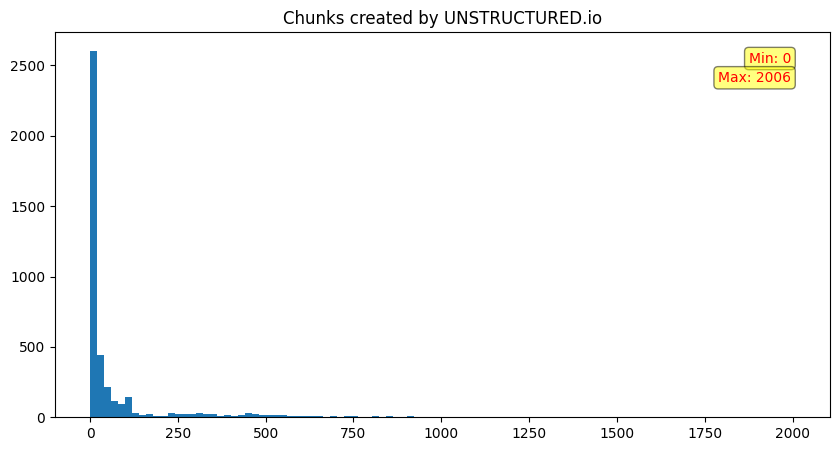

In [66]:
chunk_len = []
for element in elements:
    chunk_len.append(len(str(element)))

plot_chunks(chunk_len, "Chunks created by UNSTRUCTURED.io")

### Splitting documents via SemanticChunker
At a high level, this splits into sentences, then groups into groups of 3 sentences, and then merges one that are similar in the embedding space.

Note: Langchain Experimental library, versioning issues persist. Code for reference

In [ ]:
!pip install --quiet langchain_experimental langchain_openai
from langchain_experimental.text_splitter import SemanticChunker

text_splitter = SemanticChunker(embeddings)

semantic_docs = text_splitter.create_documents(doc_pages)
print(semantic_docs[0].page_content)
print(len(semantic_docs))

### Embeddings and Vectordb

In [60]:
import shutil

chroma_persist_directory = "processed_data"
db_path = os.path.join(chroma_persist_directory)

# Create or load Chroma Vector Database, checking is location is empty
if os.path.exists(db_path) and not os.listdir(db_path): 
    print("Creating new Chroma database...")
    vectordb = Chroma.from_documents(
            documents=RCTS_chunked_documents,
            embedding=embeddings,
            persist_directory=chroma_persist_directory
        )
    vectordb.persist()
else:
    print("Loading existing Chroma database...")
    vectordb = Chroma(persist_directory=chroma_persist_directory, 
                      embedding_function= embeddings)
    

print("Vector database loaded successfully!")

Loading existing Chroma database...
Vector database loaded successfully!


In [164]:
import re
def retrieve_merge_docs(message,vectordb, k=5):
    """
    Retrieves similar documents from a vector database, merges them into a single string, and removes extra spaces and newlines.

    Args:
        message (str): The message to search for similar documents.
        vectordb (Chroma): The vector database to search.
        k (int, optional): The number of similar documents to retrieve. Defaults to 5.
    Returns:
        tuple: A string containing the merged documents and the list of retrieved documents.
    """
    docs = vectordb.similarity_search(message, k)

    # Printing document metadata (for debugging/understanding)
    print("Printing page content and metadata of first document:")
    print("="*20)
    print(type(docs[1].page_content))
    print(docs[1].page_content)
    print("="*20)
    print(type(docs[1].metadata))
    print(docs[1].metadata)
    

    merged_docs = "\n".join([doc.page_content for doc in docs])
    #merged_docs = re.sub(r'\s+', ' ', merged_docs)  # Remove extra spaces
    return merged_docs, docs

testing retrieval with message4

In [62]:
# Example Usage (assuming you have a 'vectordb' instance):
docs_str, _ = retrieve_merge_docs(message4,vectordb, 5)
print(docs_str)

<class 'str'>
Fees Billed by the Independent Registered Public Accounting Firm 
The following is a summary of fees billed by PwC for Fiscal 2023 and 2022 for audit, tax and other professional services 
during each fiscal year: 
Fiscal 2023 Fiscal 2022
Audit Fees (1)
$ 6,858,279 $ 6,762,002 
Audit Related Fees (2)
 243,400  491,100 
Tax Fees (3)
 1,189,263  708,680 
All Other Fees (4)
 17,858  12,900 
Total Fees$ 8,308,800 $ 7,974,682 
(1)For the audit of our consolidated financial statements, including business combination activities during the year, the audit of our internal control over 
financial reporting, review of our quarterly financial statements and annual reports, review of SEC registration statements and related consents, review 
of SEC filings for public debt financing and related comfort letters, and fees related to statutory audits of some of our international entities.
<class 'dict'>
{'page': 86, 'source': '/Users/wenda/Downloads/RAGFinanceChatBot-main/data/docs/nvidia-2

Testing LLM outputs 


In [63]:
print("For the Question: ", message4)

For the Question:  What was the Total Fees Billed by the Independent Registered Public Accounting Firm in Fiscal 2023 for NVIDIA?


In [69]:
from openai import OpenAI
client = OpenAI()
def query_chatgpt(system_prompt: str, message: str, model: str = "gpt-4o-mini", temperature: float = 0.0) -> str:
    """
    Sends a query to ChatGPT and returns the response.

    Args:
        system_prompt (str): The system prompt to send to ChatGPT.
        message (str): The message to send to ChatGPT.
        model (str, optional): The model to use for the query. Defaults to "gpt-3.5-turbo".
        temperature (float, optional): The temperature to use for the query. Defaults to 0.0.

    Returns:
        str: The response from ChatGPT.
    """
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": message}
        ],
        temperature=temperature
    )
    print(f"Running {model}...")
    return response.choices[0].message.content

def format_retriver(docs_str: str, msg:str) -> str:
    return f"Retrieved Content: {docs_str}\nUser Question: {msg}"

In [70]:
print(query_chatgpt(system_prompt,format_retriver(docs_str, message4)))

Running gpt-3.5-turbo...
New question: 

The total fees billed by the Independent Registered Public Accounting Firm in Fiscal 2023 for NVIDIA was $8,308,800.

Source


### Testing Query Rewriting

For demo purpose, I have used chatgpt itself to test the query re-writing process.
We can use smaller models, that can achieve this task efficiently and process better prompts. 

In [130]:
print("Original Query: ", incomplete_messg)

Original Query:  Revenue NVIDIA?


In [131]:
print("Updated query: ", query_chatgpt(query_rewriting_prompt, incomplete_messg))

Running gpt-3.5-turbo...
Updated query:  What was NVIDIA's total revenue in the last fiscal year, and how does it compare to the previous fiscal year?


**Observations:** The resulting query has broader context and is more relevant for our use case, this helps in retriving better docs.


### Testing Reranking

I am using Colbert to rerank the relvant docs. It is good for enhancing the relevance and quality of their RAG-based applications.
- Advantages: ColBERT provides a competitive balance of performance and accuracy, making it suitable for large-scale RAG applications.
- Other Reranking options: cross-encoders

Having used Colbert here, instead other options could have been considered as well.
other models to consider: 
- Rerank using GPT-4, mistral and cohere. 

In [13]:
!pip install --quiet transformers torch

In [101]:
from transformers import AutoTokenizer, AutoModel

# Load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("colbert-ir/colbertv2.0")
model = AutoModel.from_pretrained("colbert-ir/colbertv2.0")

In [117]:
import torch

start = time.time()
scores = []

# Function to compute MaxSim
def maxsim(query_embedding, document_embedding):
    # Expand dimensions for broadcasting
    expanded_query = query_embedding.unsqueeze(2)
    expanded_doc = document_embedding.unsqueeze(1)

    # Compute cosine similarity across the embedding dimension
    sim_matrix = torch.nn.functional.cosine_similarity(expanded_query, expanded_doc, dim=-1)

    # Take the maximum similarity for each query token (across all document tokens)
    max_sim_scores, _ = torch.max(sim_matrix, dim=2)

    # Average these maximum scores across all query tokens
    avg_max_sim = torch.mean(max_sim_scores, dim=1)
    return avg_max_sim

# encodingthe query
query_encoding = tokenizer(message3, return_tensors='pt')
query_embedding = model(**query_encoding).last_hidden_state.mean(dim=1)

_, docs = retrieve_merge_docs(message3, vectordb, 10)
# Getting score for each document
for document in docs:
    document_encoding = tokenizer(document.page_content, return_tensors='pt', truncation=True, max_length=512)
    document_embedding = model(**document_encoding).last_hidden_state

    # Calculate MaxSim score
    score = maxsim(query_embedding.unsqueeze(0), document_embedding)
    scores.append({
        "score": score.item(),
        "document": document.page_content,
    })

print(f"Took {time.time() - start} seconds to re-rank documents with ColBERT.")

<class 'str'>
Alphabet Inc.
CONSOLIDATED STATEMENTS OF INCOME
(in millions, except per share amounts)
 Year Ended December 31,
 2021 2022 2023
Revenues $ 257,637 $ 282,836 $ 307,394 
Costs and expenses:
Cost of revenues  110,939  126,203  133,332 
Research and development  31,562  39,500  45,427 
Sales and marketing  22,912  26,567  27,917 
General and administrative  13,510  15,724  16,425 
Total costs and expenses  178,923  207,994  223,101 
Income from operations  78,714  74,842  84,293 
Other income (expense), net  12,020  (3,514)  1,424 
Income before income taxes  90,734  71,328  85,717 
Provision for income taxes  14,701  11,356  11,922 
Net income $ 76,033 $ 59,972 $ 73,795 
Basic net income per share of Class A, Class B, and Class C stock $ 5.69 $ 4.59 $ 5.84 
Diluted net income per share of Class A, Class B, and Class C stock $ 5.61 $ 4.56 $ 5.80 
See accompanying notes.Table of Contents Alphabet Inc.
52.
<class 'dict'>
{'page': 52, 'source': '/Users/wenda/Downloads/RAGFinanc

In [118]:
print("Without reranking: ")
for doc in docs:
    print(doc.page_content)
    print()

Without reranking: 
•Capital expenditures, which primarily reflected investments in technical infrastructure, were $32.3 billion  for the 
year ended December 31, 2023 .
•As of December 31, 2023 , we had  182,502  employees.
Financial Results
Revenues
The following table presents revenues by type (in millions):
Year Ended December 31,
2022 2023
Google Search & other $ 162,450 $ 175,033 
YouTube ads  29,243  31,510 
Google Network  32,780  31,312 
Google advertising  224,473  237,855 
Google subscriptions, platforms, and devices  29,055  34,688 
Google Services total  253,528  272,543 
Google Cloud  26,280  33,088 
Other Bets  1,068  1,527 
Hedging gains (losses)  1,960  236 
Total revenues $ 282,836 $ 307,394 
Google Services
Google advertising revenues
Google Search & other
Google Search & other revenues increased  $12.6 billion  from 2022  to 2023 . The overall growth was driven by 
interrelated factors including increases in search queries resulting from growth in user adoption and 

In [119]:
import json
# Sort the scores by highest to lowest and print
sorted_data = sorted(scores, key=lambda x: x['score'], reverse=True)
top5_data = sorted_data[:5]
print(json.dumps(top5_data, indent=2))

[
  {
    "score": 0.7800108790397644,
    "document": "Executive Overview\nThe following table summarizes our consolidated financial results (in millions, except for per share information \nand percentages):\nYear Ended December 31,\n2022 2023 $ Change % Change\nConsolidated revenues $ 282,836 $ 307,394 $ 24,558  9 %\nChange in consolidated constant currency revenues(1) 10 %\nCost of revenues $ 126,203 $ 133,332 $ 7,129  6 %\nOperating expenses $ 81,791 $ 89,769 $ 7,978  10 %\nOperating income $ 74,842 $ 84,293 $ 9,451  13 %\nOperating margin  26 %  27 %  1 %\nOther income (expense), net $ (3,514) $ 1,424 $ 4,938 NM\nNet income $ 59,972 $ 73,795 $ 13,823  23 %\nDiluted EPS $ 4.56 $ 5.80 $ 1.24  27 %\nNM = Not Meaningful\n(1) See \"Use of Non-GAAP Constant Currency Information \" below for details relating to our use of constant currency information. \n\u2022Revenues were $307.4 billion , an increase  of 9% year over year, primarily driven by an increase  in Google"
  },
  {
    "score

**Observations:**
- The output obtained after reranking bas better scores and seems to aligns with the our query.
- Can help in reducing the amount of irrelevant contextual text to LLM for processing, hence reducing  the costs and improving results.

### Performing prompt compression and rank relevant docs

In [144]:
!pip install accelerate
!pip install llmlingua

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [84]:
from llmlingua import PromptCompressor
import json

llm_lingua = PromptCompressor(
    model_name=   "microsoft/llmlingua-2-bert-base-multilingual-cased-meetingbank", # can use microsoft/phi-2, TheBloke/Llama-2-7b-Chat-GPTQ (8GB GPU needed)
    model_config={"revision": "main"},
    use_llmlingua2=True,
    device_map="cpu",
)

def compress_query_prompt(demonstration_str,instruction , question):

    # performing Compression now
    compressed_prompt = llm_lingua.compress_prompt(
        demonstration_str.split("\n"), 
        instruction=instruction,
        question=question,
        target_token=1000,
        rank_method="longllmlingua", 
        context_budget="+100",
        dynamic_context_compression_ratio=0.4,
        reorder_context="sort",
    )

    return json.dumps(compressed_prompt, indent=4)


In [96]:
merged_docs, docs = retrieve_merge_docs(message4, vectordb, 10)
print("Numebr of docs retrieved: ", len(docs))

<class 'str'>
Fees Billed by the Independent Registered Public Accounting Firm 
The following is a summary of fees billed by PwC for Fiscal 2023 and 2022 for audit, tax and other professional services 
during each fiscal year: 
Fiscal 2023 Fiscal 2022
Audit Fees (1)
$ 6,858,279 $ 6,762,002 
Audit Related Fees (2)
 243,400  491,100 
Tax Fees (3)
 1,189,263  708,680 
All Other Fees (4)
 17,858  12,900 
Total Fees$ 8,308,800 $ 7,974,682 
(1)For the audit of our consolidated financial statements, including business combination activities during the year, the audit of our internal control over 
financial reporting, review of our quarterly financial statements and annual reports, review of SEC registration statements and related consents, review 
of SEC filings for public debt financing and related comfort letters, and fees related to statutory audits of some of our international entities.
<class 'dict'>
{'page': 86, 'source': '/Users/wenda/Downloads/RAGFinanceChatBot-main/data/docs/nvidia-2

In [97]:
print("Length of prompt with no compression: ")
print("Characters in merged docs: ", len(merged_docs))
print("Characters in message4: ", len(message4))
print("Characters in system prompt: ", len(system_prompt))
print("Total number of characters: ", len(merged_docs) + len(message4) + len(system_prompt))

Length of prompt with no compression: 
Characters in merged docs:  8783
Characters in message4:  110
Characters in system prompt:  790
Total number of characters:  9683


In [98]:
print(compress_query_prompt(merged_docs, system_prompt, message4))

{
    "compressed_prompt": "Report Independent Accounting\n\nBoard Directors Shareholders NVIDIA\n\nOpinions Financial Statements Control Financial\n\naudited balance sheets NVIDIA Corporation subsidiaries\n\nJanuary 29 2023 January 30 2022 consolidated statements income\n\nincome shareholders equity cash flows three years ended January 29\n\n2023 including related notes financial statement schedule index Item 15 ( a\n\nreferred consolidated financial statements audited Company ' s internal\n\nfinancial reporting January 29 2023 criteria Control Framewor\n\n2013 Committee Treadway Commission COSO\n\nBilled Independent Accounting\n\nsummary fees PwC Fiscal 2023 2022 audit tax professional\n\nfiscal year\n\nFiscal 2023\n\nAudit Fees\n\n6, 858 279 6 762\n\nAudit Fees\n\n243 400 491\n\nTax Fees\n\n1 189 263 708\n\nOther Fees\n\n17 858 12\n\nFees 8 308 800 7 974\n\naudit consolidated financial statements including business combination activities year audit internal control\n\nfinancial repo

#### Observations: 

There is some reduction in hte token length that can be helpful to reduce the latency and cost while calling AI models with relevant context, user query and prompt. 

These can be cached and stored, that can be used as replacements in the future hence reducing the time and cost of prompt reduction. 

More testing is needed to verify to check if relevant data loss is happening. 

### Testing Query Expansion

Query expansion is a useful tool for imprvoing the accuracy of search results. Especially,  when the original query is too broad and. When the query parser adds additional terms to the query, the system can narrow down the search and retrieve more relevant results.



In [67]:
print(query_expansion_prompt)

 You are a financial analyst assistant that breaks down a user's financial analysis query into sub-queries.    The sub-queries should be mutually exclusive and collectively exhaustive, focusing on different aspects of financial analysis.    Your response will be a JSON object with a `queries` field, which is a list of `query` objects, each detailing a specific aspect of the financial analysis.    Additionally, include examples (few-shot prompting) to guide the user on how to formulate their queries for optimal results.
    


In [74]:
query_compressed = "What was the revenue of Alphabet, NVIDIA, and Microsoft in the last fiscal year? Who are the CEOs of these companies?"

In [75]:
print(query_chatgpt(query_expansion_prompt, query_compressed))

Running gpt-3.5-turbo...
{
    "queries": [
        {
            "query": "What was the revenue of Alphabet in the last fiscal year?",
            "company": "Alphabet"
        },
        {
            "query": "What was the revenue of NVIDIA in the last fiscal year?",
            "company": "NVIDIA"
        },
        {
            "query": "What was the revenue of Microsoft in the last fiscal year?",
            "company": "Microsoft"
        },
        {
            "query": "Who is the CEO of Alphabet?",
            "company": "Alphabet"
        },
        {
            "query": "Who is the CEO of NVIDIA?",
            "company": "NVIDIA"
        },
        {
            "query": "Who is the CEO of Microsoft?",
            "company": "Microsoft"
        }
    ]
}


#### Observations: 

The model is able to break complex queries into relevant queries, which will help in successful retrievals of complex and vague queries. 
We can utilise a smaller and inexpensive model for this task, in practise. 
- Retreival efficiency improves
- Relevant information for each sub-query is extracted.

Cons:
- more queries to generated for LLM to process

### Testing Nemo Gaurdrailings

We can use any LLM provider that is supported by LangChain, e.g., `ai21`, `aleph_alpha`, `anthropic`, `anyscale`, `azure`, `cohere`, `huggingface_endpoint`, `huggingface_hub`, `openai`, `self_hosted`, `self_hosted_hugging_face`. 



In [97]:
from nemoguardrails import LLMRails, RailsConfig
from nemoguardrails.integrations.langchain.runnable_rails import RunnableRails
from langchain_core.runnables import Runnable
from langchain_groq import ChatGroq
import nest_asyncio

nest_asyncio.apply()

In [94]:
config = RailsConfig.from_path("./config")

class CheckKeywordsRunnable(Runnable):
    def invoke(self, input, config = None, **kwargs):
        text = input["text"]
        keywords = input["keywords"].split(",")
        for keyword in keywords:
            if keyword.strip() in text:
                return True

        return False

print(CheckKeywordsRunnable().invoke({"text": "This is a proprietary message", "keywords": "proprietary"}))

True


In [95]:
config = RailsConfig.from_path("config")
rails = LLMRails(config)

rails.register_action(CheckKeywordsRunnable(), "check_keywords")

In [101]:
response = rails.generate("Give me some proprietary information.")
print("="*20)
print(response)

I'm sorry, I can't respond to that.


**Observations:**

This setup allows the chatbot to use the custom action `CheckKeywordsRunnable` to check for specific keywords in text, enhancing its functionality based on the defined actions.

This can be extended to the prompt being given to the model as well. This will ensure that the gaurrails are followed strictly and do not output unecessary, irrelevant and harmful content to the user. 

##  Evaluation
- M1: We can use the chat history being collected at Langsmith for curatinging dataset for further enhancements and insights. 
- M2: First create a golden dataset, by using human annotators/large strong models (at par with human skills in terms of annotations and evaluations.)
  - Later the results of our models can be evaluated against the golden set of responses.
  - Domain-Specific Benchmarks can be used for evaluation.
  - [Beir Benchmarking](https://github.com/beir-cellar/beir) for heterogeneous IR tasks. 


### Using RAGAS

In [ ]:
!pip install ragas==0.1.0

In [155]:
from datasets import Dataset

questions = ["Who is the CEO of Alphabet?",
             "What was the balance at the end of the year for the allowance for credit losses and sales credits of Alphabet in 2022?", # Alphabet: USD 1,213 | pg 92
             "What was the median employee compensation at NVIDIA in Fiscal 2023?",
            ]
ground_truths = [["The CEO of Alphabet is Sundar Pichai."],
                ["The balance at the end of the year for the allowance for credit losses and sales credits in 2022 was $1,213 million."],
                ["The median employee compensation at NVIDIA in Fiscal 2023 was $228,078."]]
answers = []
contexts = []

# Inference
for query in questions:
  print(f"Query: {query}")
  updated_query, _ = retrieve_merge_docs(query, vectordb, 10)
  ans = query_chatgpt(system_prompt, updated_query)
  answers.append(ans)
  print(f"Answer: {ans}") # {ans)

  cntxt = [docs.page_content for docs in retriever.get_relevant_documents(query)]
  contexts.append(cntxt)
  print(f"Context: {cntxt}")

# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)
     

Query: Who is the CEO of Alphabet?
<class 'str'>
Roger W. Ferguson Jr.
/S/    J OHN L. H ENNESSY         Director, Chair January 30, 2024
John L. Hennessy
/S/    L ARRY  PAGE        Co-Founder and Director January 30, 2024
Larry Page
/S/    K. R AM SHRIRAM       Director January 30, 2024
K. Ram Shriram
/S/    R OBIN L. W ASHINGTON       Director January 30, 2024
Robin L. WashingtonTable of Contents Alphabet Inc.
96.
<class 'dict'>
{'page': 96, 'source': '/Users/wenda/Downloads/RAGFinanceChatBot-main/data/docs/alphabet-2023.pdf'}
Running gpt-3.5-turbo...
Answer: I'm sorry, but I couldn't find a specific question in the provided content. How can I assist you today?
Context: ["us to tackle big problems and invest in moonshots . It led us to be a pioneer in the development of AI and, since 2016, \nan AI-first company. We continue this work under the leadership of Alphabet and Google CEO, Sundar Pichai.\nAlphabet is a collection of businesses — the largest of which is Google. We report Goog

Now evaluating with RAGAS

In [156]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)

df = result.to_pandas()

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

In [159]:
df.head()

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Who is the CEO of Alphabet?,"I'm sorry, but I couldn't find a specific ques...",[us to tackle big problems and invest in moons...,[The CEO of Alphabet is Sundar Pichai.],The CEO of Alphabet is Sundar Pichai.,0.715278,1.0,NaN,0.000000
1,What was the balance at the end of the year fo...,# Retrieved content number: 3\n\nOperating inc...,[Balance at\nBeginning of Year Additions Usage...,[The balance at the end of the year for the al...,The balance at the end of the year for the all...,0.700000,1.0,1.0,0.838616
2,What was the median employee compensation at N...,New question: \n\nBased on the information pro...,"[median of our peer group companies, which was...",[The median employee compensation at NVIDIA in...,The median employee compensation at NVIDIA in ...,0.066667,1.0,0.0,0.860674


**Observations: **
We can see on a sample dataset we are getting results. This provides an insight on how we can evaluate the model's response and w.rt. golden data set. 


There is need to curate data using more care and we can also seek help from large LLMs, given them a portion of our page/section to generate questions and answers. 